In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange

Why do we use sinusoidal positional encodings?

Look at the functions. For a dimension (i) the sin/cos function's wave starts out extremely quickly changing values for small i, and slows down a lot up to a wavelength of 10000.2pi.

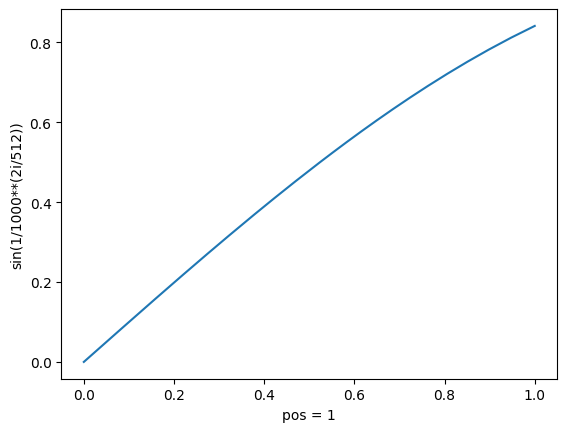

In [7]:
d_model = 512
sin_denom = [1000**((2*i)/d_model) for i in range(0, 512, 2)]
cos_denom = [1000**(((2*i)+1)/d_model) for i in range(1, 512, 2)]
np_sin_denom = np.array(sin_denom, dtype=np.float32)
np_cos_denom = np.array(cos_denom, dtype=np.float32)

pos_1_sin_x = 1 / np_sin_denom
pos_1_sin_y = np.sin(pos_1_sin_x)
plt.plot(pos_1_sin_x, pos_1_sin_y)
plt.xlabel('pos = 1')
plt.ylabel('sin(1/1000**(2i/512))')
plt.show()

## Sinuoidal Positional Encoding
Task is:
Given a position $pos$ output a vector $d_{model}$ such that for each location $i$ in the vector the output is $$PE_{pos,2i} = \sin(pos/10000^{2i/d_{model}})$$ $$PE_{pos,2i+1} = \cos(pos/10000^{2i/d_{model}})$$
for even and odd indices respectively

we refactor as $$PE_{pos,2i} = \sin(pos.w)$$ $$PE_{pos,2i+1} = \cos(pos.w)$$ where $w=1/(10000^{2i/d_{model}}) for 0 <= 2i <= d_{model}$

In [94]:
# output pe -> [d_model]
def sinusoidal_position_encoding(pos: int, d_model: int = 512) -> torch.tensor:
    # w = 1/10000**(2i/d_model)
    w = torch.tensor([1/(10000**(k/d_model)) for k in range(0, d_model, 2)])
    x_indices = pos * w 
    PE_even = torch.sin(x_indices)
    PE_odd = torch.cos(x_indices)
    PE_even = rearrange(PE_even, "(new_dim l) -> l new_dim", new_dim=1)
    PE_odd = rearrange(PE_odd, "(new_dim l) -> l new_dim", new_dim=1)
    interleaved_result = rearrange([PE_even, PE_odd], "function d_model element -> (d_model element function)")
    assert (interleaved_result.shape == (d_model,))
    return interleaved_result

In [96]:
print(sinusoidal_position_encoding(1, 4))

tensor([0.8415, 0.5403, 0.0100, 0.9999])


In [97]:
print(sinusoidal_position_encoding(2, 4))

tensor([ 0.9093, -0.4161,  0.0200,  0.9998])


#### Function that calculates attention (single-headed for now).

In [33]:
import torch
from torch import nn
from einops import rearrange, einsum

from typing import Optional
import math
from collections import OrderedDict

In [ ]:
def scaled_dot_prd_attention(Q, K, V, mask: bool = False):
    assert (Q.shape == K.shape)

    K_t = rearrange(K, "dm dk -> dk dm")

    QK_t = einsum(Q, K_t, "i dk, dk k -> i k")
    scaled_QK_t = QK_t / (math.sqrt(d_model))
    # since we want to average the attended keys between the dimension d_k
    if mask:
        attention_mask = torch.full(scaled_QK_t.shape, False, requires_grad=False)
        for dim0 in range(attention_mask.shape[0]):
            for dim1 in range(attention_mask.shape[1]):
                if dim1 > dim0:
                    attention_mask[dim0, dim1] = True
        assert (attention_mask.shape == scaled_QK_t.shape)
        scaled_QK_t.masked_fill_(attention_mask, float("-inf"))
    print(scaled_QK_t)
    weighted_keys = torch.softmax(scaled_QK_t, dim=1)
    print(weighted_keys)
    attention_output = einsum(weighted_keys, V, "input_len input_len, input_len dv -> input_len dv")
    return attention_output


In [29]:
input_length, d_k, d_v = 512, 512, 512
Q = torch.randn([input_length, d_k], dtype=torch.float32)
K = torch.randn([input_length, d_k], dtype=torch.float32)
V = torch.randn([input_length, d_v], dtype=torch.float32)
scaled_dot_prd_attention(Q, K, V, mask=True)

tensor([[ 0.6263,  1.2587,  1.0444,  ...,  2.2483,  0.9847, -0.5333],
        [ 0.0000, -0.4944, -0.2343,  ..., -0.6481, -0.5001,  2.0218],
        [ 0.0000,  0.0000, -0.3240,  ..., -2.1367, -0.9365, -1.3077],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.4101, -2.3363, -0.0670],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.2210, -0.3642],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.1448]])
tensor([[ 0.6263,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        [ 0.0000, -0.4944,    -inf,  ...,    -inf,    -inf,    -inf],
        [ 0.0000,  0.0000, -0.3240,  ...,    -inf,    -inf,    -inf],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.4101,    -inf,    -inf],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.2210,    -inf],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.1448]])
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.2114e-01, 3.7886e-01, 0.

tensor([[-1.5476e+00, -8.8049e-01,  3.6044e-01,  ...,  1.5768e-01,
          2.6848e-01,  3.4911e-01],
        [-5.5044e-01,  6.8291e-02, -7.9834e-01,  ..., -1.7824e-01,
         -5.8716e-01, -5.9838e-01],
        [-2.2274e-01, -2.7328e-01, -6.5209e-01,  ..., -9.9067e-02,
         -6.6150e-02,  6.6993e-02],
        ...,
        [-2.0917e-03, -2.1781e-03, -1.2657e-02,  ...,  9.8242e-03,
          4.5074e-03,  5.5943e-03],
        [ 8.8999e-04,  3.1374e-04,  3.2082e-04,  ..., -1.0951e-04,
          1.1297e-03, -1.7214e-04],
        [-4.2918e-04, -7.0503e-04,  7.9431e-04,  ...,  1.2830e-03,
          7.1038e-04, -3.3223e-04]])

#### A Decoder-Only Transformer Language Model

For now we are implementing it with single headed attention

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_ffn: int = 2048):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(d_model, d_ffn)),
            ("relu1", nn.ReLU),
            ("linear2", nn.Linear(d_ffn, d_model)),
        ]))
    
    def forward(self, x):
        return self.layers.forward(x)

class Decoder(nn.Module):
    def __init__(self, d_model: int, d_k: int, d_v: int):
        super().__init__()
        # attention function
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.W_Q = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_K = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_V = nn.Parameter(torch.randn([self.d_model, self.d_v]), requires_grad=True)
        # normalize over the last dimension in shape [N, d_v], so each layer
        self.layernorm1 = nn.LayerNorm(self.d_v)
        self.feedforward = FeedForward(d_model=self.d_model)
        self.layernorm2 = nn.LayerNorm(self.d_model)
    
    def forward(self, input: torch.Tensor):
        # can matmuls change size in torch while training? Or do I need a fixed size that is padded with
        # lines of zeros?
        assert(input.dim == 2 and input.shape[1] == self.d_model)
        input_token_length = input.shape[0]
        Q = torch.matmul(input, self.W_Q)
        K = torch.matmul(input, self.W_K)
        V = torch.matmul(input, self.W_V)

        attn_values = scaled_dot_prd_attention(Q, K, V, mask = True)
        
        normalized_attn_values = self.layernorm1(attn_values + input)
        assert(normalized_attn_values.shape == attn_values.shape)
        assert(normalized_attn_values.dim() == 2 and normalized_attn_values.shape[1] == self.d_model)

        ffn_output = self.feedforward(normalized_attn_values)

        normalized_ffn = self.layernorm2(ffn_output + normalized_attn_values)
        return normalized_ffn

class EmbeddingLayer(nn.Module):
    def __init__(self, vector_size: int, vocab_size: int):
        super().__init__()
        self.d_model = vector_size
        self.scaling_factor = math.sqrt(self.d_model) # a detail in the paper
        self.lut = nn.Embedding(vocab_size, vector_size)
    
    def embed(self, input_indices):
        return self.lut(input_indices) * self.scaling_factor

    def get_weights(self):
        return self.lut.weight

class Transformer(nn.Module):
    def __init__(self, num_decoders: int = 6):

        super().__init__()
        assert (num_decoders >= 1)
        self.d_model = 512
        self.d_k, self.d_v = 512, 512
        self.embedding = EmbeddingLayer()
        self.decoder_stack = nn.Sequential()
        for _ in range(num_decoders):
            self.decoder_stack.append(Decoder(d_model = self.d_model, d_k = self.d_k, d_v = self.d_v))

        self.linear = nn.Linear(self.d_model, self.d_model)
        with torch.no_grad:
            self.linear.weight = self.embedding.get_weights()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input_tokens: list[str]):
        sequence_length = len(input_tokens)
        # how do we get from input tokens to indices?
        embed_tokens = self.embedding(input_tokens)
        assert(embed_tokens.dim() == 2 and embed_tokens.shape == [len(input_tokens), self.d_model])

        # Add positional encoding information
        pos_enc = torch.zeros_like(embed_tokens)
        for position in range(sequence_length):
            pos_enc[position, :] += sinusoidal_position_encoding(position, self.d_model)
        embed_tokens += pos_enc

        decoder_output = self.decoder_stack(embed_tokens)

        assert(decoder_output.dim() == 2 and decoder_output.shape == [sequence_length, self.d_model])
        linear_output = self.linear(decoder_output)

        next_token_probabilities = self.softmax(linear_output)
